In [356]:
import sys
sys.path.append('/users/stan/documents/')
import os
from glob import glob
import copy
import pandas
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as plt
%matplotlib inline
import cPickle as pickle
import spUtils
import h5py
import re
import pandas as pd


In [194]:

LayerIIIPaths = [('/Users/Stan/Dropbox/odorSet2 data/pandas .h5 version/sp030517a/sp030517a_e1_slice_3_v3.h5',3),
                 ('/Users/Stan/Dropbox/odorSet2 data/pandas .h5 version/sp030517a/sp030517a_e1_slice_4_v3.h5',4),
                 ('/Users/Stan/Dropbox/odorSet2 data/pandas .h5 version/sp030517a/sp030517a_e1_slice_5_v3.h5',5)]

LayerIIPaths = [('/Users/Stan/Dropbox/odorSet2 data/pandas .h5 version/sp030517a/sp030517a_e1_slice_0_v3.h5',0),
                 ('/Users/Stan/Dropbox/odorSet2 data/pandas .h5 version/sp030517a/sp030517a_e1_slice_1_v3.h5',1),
                 ('/Users/Stan/Dropbox/odorSet2 data/pandas .h5 version/sp030517a/sp030517a_e1_slice_2_v3.h5',2)]


odorCsvPath = '/Users/Stan/Dropbox/odorSet2 data/odorant_info.csv'

### Read in odor info



In [ ]:

odorInfo = pd.read_csv(odorCsvPath, usecols = [1,2,3,4])

odorInfo


### Read in Layer III dataframes one slice at a time and convert to array

In [198]:
allSliceArrays = []
for path, slice_ in LayerIIIPaths:

    with pd.HDFStore(path, 'r+') as f:
        print  'converting ', f.keys()[0]
        DF = f['/sp030517a_e1_slice_{}'.format(slice_)]
        
    #resort so that odorID is consecutive for each trial since odorID is pseudorandomized during the experiment
    DF = DF.groupby(['trialID', 'odorID', 'Frame']).apply(lambda x: x.reset_index(drop = True))

    # clip extra acquired frames for each odor presentation
    DF = DF.loc[DF.Frame.isin(range(233)),:]
    
    numTrials = DF.trialID.unique().shape[0]
    numCells = DF.cellID.unique().shape[0]
    numOdors = DF.odorID.unique().shape[0]
    numFrames = DF.Frame.unique().shape[0]
    
    # convert dataframe to array
    # dFF is the normalized fluorescence for each neuron. 
    unstackedByFrame = DF.dFF.unstack('Frame')

    R = np.zeros((numTrials, numCells, numOdors, numFrames))
    DFTrials = DF.trialID.unique()
    DFOdors = DF.odorID.unique()
    for i, trial in enumerate(DFTrials):
        for j, odor in enumerate(DFOdors):
            R[i, :, j, :] = unstackedByFrame.loc[(trial,odor)]
    allSliceArrays.append(R)

R = np.concatenate(allSliceArrays, axis = 1)
numTrials, numCells, numOdors, numFrames = R.shape

['/sp030517a_e1_slice_3']
['/sp030517a_e1_slice_4']
['/sp030517a_e1_slice_5']


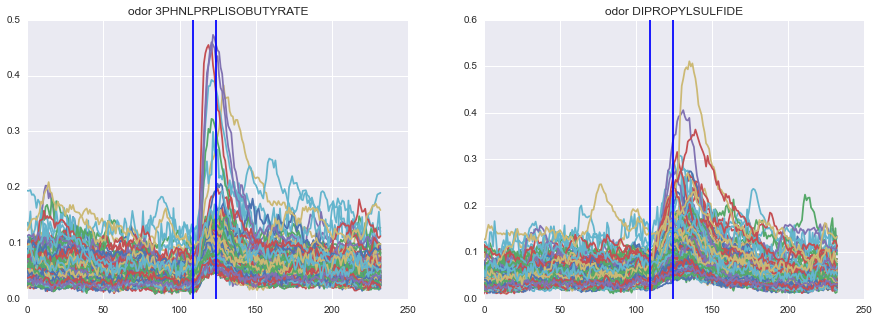

In [201]:
# plot trial-averaged responses from a bunch of cells 
odor1 = 5
odor2 = 16

fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].plot(R.mean(0)[:,odor1,:].T);
ax[1].plot(R.mean(0)[:,odor2,:].T);

ax[0].set_title('odor {}'.format(odorInfo.iloc[odor1]['name']))
ax[1].set_title('odor {}'.format(odorInfo.iloc[odor2]['name']))


# indicate odor onset and offset. 
for plot in range(ax.shape[0]):
    ax[plot].axvline(109)
    ax[plot].axvline(124)

### Embed odors using 2 PCs. 

In [347]:

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

#standardize each neuron's full-experiment trace 
zscoredR = scale(R.swapaxes(0,1).reshape(numCells, -1), axis = 1, with_mean=True, with_std=True)
zscoredR = zscoredR.reshape(numCells,numTrials,numOdors,numFrames).swapaxes(1,0)

# Use frames 109-150 to calculate the trial-averaged response
X = zscoredR[:,...,120:140].mean(0).mean(2).T

#center the odor vector on the mean
X = scale(X, axis = 1, with_std = False)


pca = PCA(n_components=3)

Z = pca.fit_transform(X)
print pca.explained_variance_ratio_
print pca.explained_variance_ratio_.sum()

plt.figure(figsize = (15,10))
plt.imshow(X, aspect = 'auto')
plt.axhline(0+.5, color = 'k')
plt.axhline(4+.5, color = 'k')
plt.axhline(7+.5, color = 'k')
plt.axhline(11+.5, color = 'k')
plt.axhline(14+.5, color = 'k')
plt.axhline(18+.5, color = 'k')
plt.xlabel('neuron')
plt.ylabel('odor')

[ 0.225262    0.14944296  0.12804965]
0.502754612409


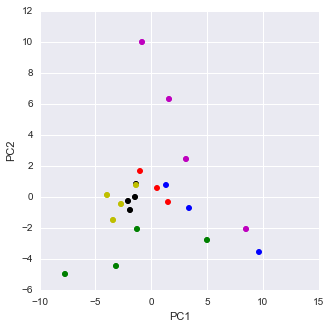

In [349]:
# from odor info:
classes = dict(furans = [1,2,3,4],
                esters = [5,6,7],
                aldehydes = [8,9,10,11],
                ketones = [12,13,14],
                sulfurs = [15,16,17,18],
                acids = [19,20,21,22])

#color each odor according to chemical class. 
cmap = ['k','r','g','b','m','y']
#sns.set_style('ticks')
fig = plt.figure(figsize = (5,5))
for i, (oclass, odorIdxs) in enumerate(classes.items()):
    for odor in odorIdxs:
        plt.scatter(Z[odorIdxs,0],Z[odorIdxs,1], color = cmap[i],s = 25)
plt.ylabel('PC2')
plt.xlabel('PC1')

## Repeat for Layer II

In [351]:
allSliceArrays = []
for path, slice_ in LayerIIPaths:

    with pd.HDFStore(path, 'r+') as f:
        print  'converting ', f.keys()[0]
        DF = f['/sp030517a_e1_slice_{}'.format(slice_)]
        
    #resort so that odorID is consecutive for each trial since odorID is pseudorandomized during the experiment
    DF = DF.groupby(['trialID', 'odorID', 'Frame']).apply(lambda x: x.reset_index(drop = True))

    # clip extra acquired frames for each odor presentation
    DF = DF.loc[DF.Frame.isin(range(233)),:]
    
    numTrials = DF.trialID.unique().shape[0]
    numCells = DF.cellID.unique().shape[0]
    numOdors = DF.odorID.unique().shape[0]
    numFrames = DF.Frame.unique().shape[0]
    
    # convert dataframe to array
    # dFF is the normalized fluorescence for each neuron. 
    unstackedByFrame = DF.dFF.unstack('Frame')

    R = np.zeros((numTrials, numCells, numOdors, numFrames))
    DFTrials = DF.trialID.unique()
    DFOdors = DF.odorID.unique()
    for i, trial in enumerate(DFTrials):
        for j, odor in enumerate(DFOdors):
            R[i, :, j, :] = unstackedByFrame.loc[(trial,odor)]
    allSliceArrays.append(R)

R = np.concatenate(allSliceArrays, axis = 1)
numTrials, numCells, numOdors, numFrames = R.shape

converting  /sp030517a_e1_slice_0
converting  /sp030517a_e1_slice_1
converting  /sp030517a_e1_slice_2


[ 0.12626528  0.10549672  0.09456332]
0.326325320305


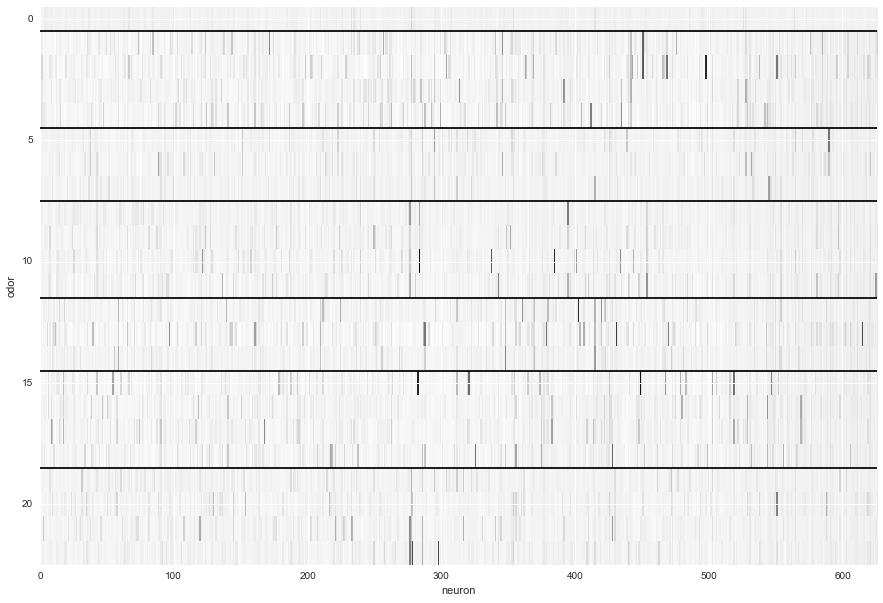

In [352]:
### Embed odors using 2 PCs. 
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

#standardize each neuron's full-experiment trace 
zscoredR = scale(R.swapaxes(0,1).reshape(numCells, -1), axis = 1, with_mean=True, with_std=True)
zscoredR = zscoredR.reshape(numCells,numTrials,numOdors,numFrames).swapaxes(1,0)

# Use frames 109-150 to calculate the trial-averaged response
X = zscoredR[:,...,120:140].mean(0).mean(2).T

#center the odor vector on the mean
X = scale(X, axis = 1, with_std = False)


pca = PCA(n_components=3)

Z = pca.fit_transform(X)
print pca.explained_variance_ratio_
print pca.explained_variance_ratio_.sum()

plt.figure(figsize = (15,10))
plt.imshow(X, aspect = 'auto')
plt.axhline(0+.5, color = 'k')
plt.axhline(4+.5, color = 'k')
plt.axhline(7+.5, color = 'k')
plt.axhline(11+.5, color = 'k')
plt.axhline(14+.5, color = 'k')
plt.axhline(18+.5, color = 'k')
plt.xlabel('neuron')
plt.ylabel('odor')

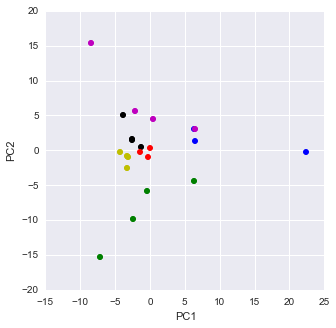

In [357]:
# from odor info:
classes = dict(furans = [1,2,3,4],
                esters = [5,6,7],
                aldehydes = [8,9,10,11],
                ketones = [12,13,14],
                sulfurs = [15,16,17,18],
                acids = [19,20,21,22])

#color each odor according to chemical class. 
cmap = ['k','r','g','b','m','y']
#sns.set_style('ticks')
fig = plt.figure(figsize = (5,5))
for i, (oclass, odorIdxs) in enumerate(classes.items()):
    for odor in odorIdxs:
        plt.scatter(Z[odorIdxs,0],Z[odorIdxs,1], color = cmap[i],s = 25)
plt.ylabel('PC2')
plt.xlabel('PC1')